In [25]:
## This Notebook will Utilize Best Subset Selection on the Hitters Dataset
## imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression



In [2]:
## Load Hitters Data from ISLP package
hitters = load_data('Hitters')
np.isnan(hitters['Salary']).sum()

## Get Categorical Variables
#print(hitters.dtypes)
categorical_cols = hitters.select_dtypes(include=['category']).columns.tolist()
#print(categorical_cols)

## Drop 59 Null Rows
hitters = hitters.dropna()

In [3]:
## Define Mallow's Cp Function, since it doesn't come with sklearn

def nCp(sigma2, estimator, X, y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((y - Yhat)**2)
    return -(RSS + 2*p*sigma2)/n

In [4]:
## One-Hot Encode the Categorical Variables
X = pd.get_dummies(hitters, drop_first=True).drop(columns=['Salary'])
y = hitters.Salary

sigma2 = OLS(y,X).fit().scale

print(sigma2)

100500.82193750181


In [7]:
## The partial function takes a funtion as an argument, and freezes some if it's arguments, starting from the left

neg_Cp = partial(nCp, sigma2)

In [29]:
## Perform Forward Selection using Sklearn LinearRegression() and SequentialFeatureSelection

## Forward Selection results in a model that has 9 features, instead of 19. This is because our scoring measure of Cp filters out some of the variables

ols = LinearRegression()
sfs = SequentialFeatureSelector(ols, n_features_to_select="auto", direction='forward', scoring=neg_Cp).fit(X,y)

sfs.get_feature_names_out()

array(['AtBat', 'Hits', 'Runs', 'Walks', 'Years', 'CRuns', 'CRBI',
       'PutOuts', 'Division_W'], dtype=object)

## Choosing Among Models Using the Validation Set Approach and Cross-Validation

C:\Users\lucas\AppData\Local\Temp\ipykernel_16952\2419575053.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  insample_mse = ((Yhat_in - y[:,None])**2).mean(0)


(50000.0, 250000.0)

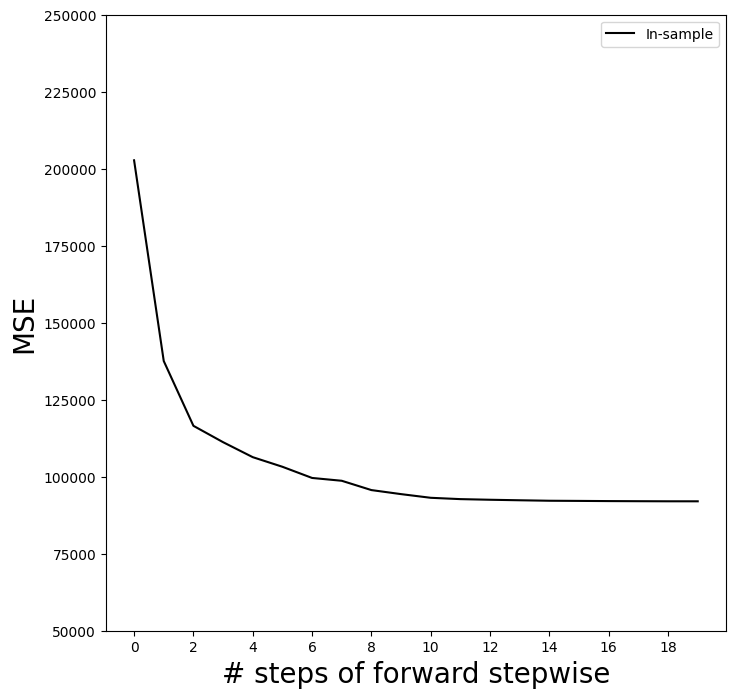

In [39]:
## As an alternative to Cp, we could use cross-validation to select our model in forward selection

## Need to store the full path of models found in forward selection, and allows predictions for each

## Going to use the Book's iteration for this

design = MS(hitters.columns.drop('Salary')).fit(hitters)

strategy = Stepwise.fixed_steps(design,
len(design.terms),
direction='forward')
full_path = sklearn_selection_path(OLS, strategy)
full_path.fit(hitters, y)
Yhat_in = full_path.predict(hitters)
Yhat_in.shape

mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
insample_mse,
'k', # color black
label='In-sample')
ax.set_ylabel('MSE',
fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000])

## As expected, MSE is reduced with each step

In [45]:
K=5
kfold = skm.KFold(
    K,
    random_state=0,
    shuffle=True
    )

Yhat_cv = skm.cross_val_predict(
    full_path,
    hitters,
    y,
    cv=kfold
    )

Yhat_cv.shape

(263, 20)

C:\Users\lucas\AppData\Local\Temp\ipykernel_16952\674238535.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  errors = (Yhat_cv[test_idx] - y[test_idx,None])**2


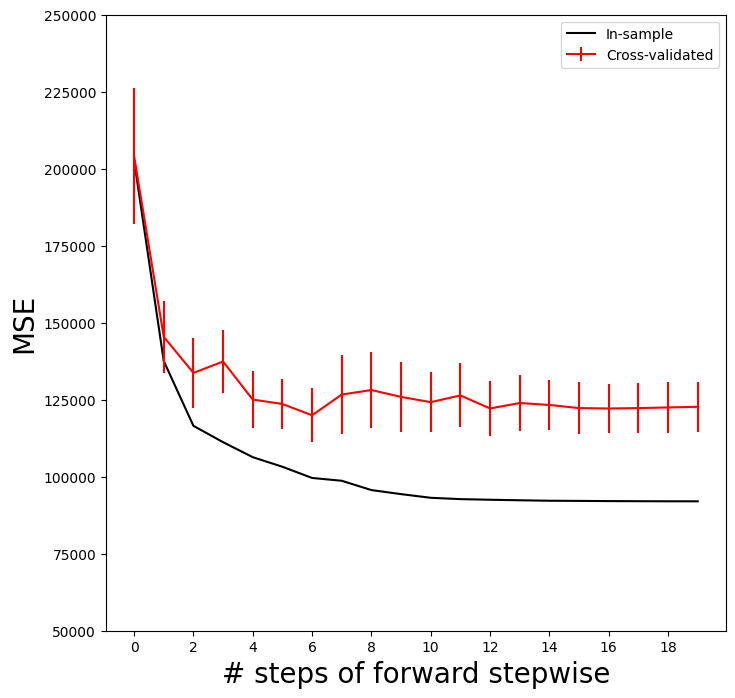

In [57]:
cv_mse = []
for train_idx, test_idx in kfold.split(y):
    errors = (Yhat_cv[test_idx] - y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

ax.errorbar(np.arange(n_steps),
cv_mse.mean(1),
cv_mse.std(1) / np.sqrt(K),
label='Cross-validated',
c='r') # color red
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

In [ ]:
## Not going to do best Subset Selection since it isn't typically used in practice